# 🥱 LangGraph 篇_Human_in_the_loop(人機迴圈)

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).

## 環境建置

### 安裝套件包

在本演練中，

我們將使用以下套件：

In [1]:
%pip install --upgrade --quiet langchain
%pip install --upgrade --quiet langchain-openai
%pip install --upgrade --quiet langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 14.4 MB/s eta 0:00:00


我們需要設置 環境變數 OPENAI_API_KEY ，可以直接完成，如下所示：

In [2]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### (可用可不用)LangSmith

你用LangChain構建的許多應用程式將包含多個步驟，並多次調用LLM調用。隨著這些應用程式變得越來越複雜，能夠檢查您的鏈或代理內部到底發生了什麼變得至關重要。最好的方法是與[LangSmith](https://smith.langchain.com)合作。

請注意，LangSmith 不是必需的，但它很有説明。如果您確實想使用 LangSmith，請在上面的鏈接中註冊后，請確保設置環境變數以開始記錄跟蹤：

In [ ]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "false" ##想要使用記得改 true, 不要時改 false.
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## 安裝與版本檢查

In [3]:
import sys, platform, importlib
print("Python:", sys.version)
print("OS:", platform.platform())

# 確認 langgraph 可成功匯入
langgraph = importlib.import_module("langgraph")
print("langgraph 版本：", getattr(langgraph, "__version__", "未知"))

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
OS: Linux-6.1.123+-x86_64-with-glibc2.35
langgraph 版本： 未知


## 定義共享狀態與必要節點（含 HIL 節點）
我們定義構成工作流程的各個節點。這些節點可以是AI任務，也可以是我們人機迴圈的關鍵點。

In [12]:
import uuid
from typing import TypedDict, Literal

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver  # 用於檢查點儲存（開發測試）
from langgraph.types import interrupt, Command         # HIL 核心功能：中斷與命令導向

# ---- 共用狀態（會在節點間傳遞）----
class State(TypedDict):
    llm_output: str  # 儲存 LLM 生成的內容（此範例以假資料模擬）
    decision: str    # 儲存人類的決定（'approved' 或 'rejected'）

In [13]:
# 節點一：LLM 輸出模擬（實際應用中會是真正的 LLM 呼叫）
def generate_llm_output(state: State) -> State:
    # 實際應用中，這裡會呼叫 LLM 產生報告內容
    return {"llm_output": "這是一份需要批准的 LLM 生成報告，內容關於「市場進入策略」。"}

# 節點二：人類審核與決策（人機迴圈點）----
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    print("\n---節點：等待人類審核---")
    print(f"請審閱以下內容：\n{state['llm_output']}\n")

    # 使用 interrupt() 暫停圖形執行，並將資訊呈現給人類
    # interrupt()的回傳值將會是人類透過 Command(resume=...) 注入的資料
    user_decision = interrupt({
        "question": "您是否批准此報告？請輸入 'approve'（批准） 或 'reject'（拒絕）",
        "content_to_review": state["llm_output"],
    })

    #根據人類輸入決定後續路徑
    if str(user_decision).strip().lower() == "approve":
        print("✅ 人類已批准，導向『批准』路徑")
        # (2)! 使用Command(goto=...) 導向到指定的節點，並可同時更新狀態
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        print("❌ 人類已拒絕，導向『拒絕』路徑")
        # (3)! 導向拒絕路徑
        return Command(goto="rejected_path", update={"decision": "rejected"})

# ---- 節點三：批准後的執行路徑 ----
def approved_node(state: State) -> State:
    print("--- 節點：在『批准』路徑中執行 ---")
    print(f"報告已批准，可進行後續操作（例如：發送報告）。最終決策：{state.get('decision')}")
    return state

# ---- 節點四：拒絕後的執行路徑 ----
def rejected_node(state: State) -> State:
    print("🛑 節點：在『拒絕』路徑中執行")
    print(f"報告被拒絕，未執行後續操作。最終決策：{state.get('decision')}")
    return state

在human_approval節點中，interrupt() 是實現人機迴圈的核心。它會暫停圖形執行，並將 { "question": ..., "content_to_review": ... } 這個字典傳送給外部等待人類輸入。當人類透過Command(resume=...) 恢復執行時，interrupt() 的返回值就是resume所帶入的值（例如 "approve" 或 "reject"）。接著，我們利用Command(goto=...) 來根據人類的決策，動態地將工作流程導向不同的後續節點，實現決策分流。

## 建構與編譯圖形（啟用記憶體檢查點）

現在，我們將這些節點組合成一個LangGraph圖形，設定入口點和節點之間的連接關係。

In [14]:
# 建立圖形實例，並加入節點
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

# 設定起點與流向
builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
# human_approval 會直接用 Command(goto=...) 控制往哪個節點
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

# 編譯＋啟用檢查點（沒有它就無法中斷/恢復）
checkpointer = InMemorySaver()   # 正式環境請改為持久化儲存（例如資料庫）
graph = builder.compile(checkpointer=checkpointer)

print("✅ 圖形編譯完成（已啟用 InMemorySaver）")


✅ 圖形編譯完成（已啟用 InMemorySaver）


這裡我們使用了StateGraph來定義一個圖，並透過add_node和add_edge來連結節點。特別重要的是，我們在compile時指定了一個checkpointer。沒有checkpointer，interrupt功能將無法運作，因為它無法儲存和恢復中斷時的圖形狀態。

## 可視化結果

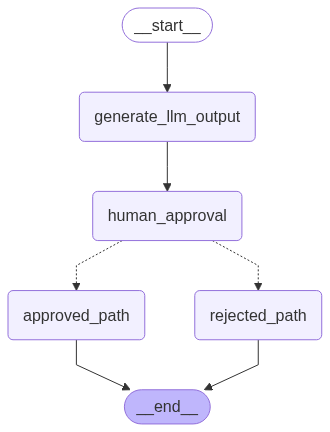

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

##執行與恢復工作流程
最後，我們將實際執行這個圖形，模擬人類介入的過程。

In [15]:
# 執行與恢復工作流程（單一 cell）
import uuid
from langgraph.types import Command

# 第一次執行圖形，這會從 "generate_llm_output" 開始，然後暫停在 "human_approval"
# 必須提供一個唯一的thread_id，用於追蹤特定的會話狀態
thread_id = str(uuid.uuid4())
thread_config = {"configurable": {"thread_id": thread_id}}

print(f"\n--- 第一次執行圖形 (Thread ID: {thread_id}) ---")
print("LLM將生成輸出，然後流程會中斷，等待人類批准/拒絕。")

# 呼叫invoke()，當遇到interrupt時會返回帶有 '__interrupt__' 鍵的結果
first_result = graph.invoke({}, config=thread_config)

# 檢查是否因interrupt而中斷
if '__interrupt__' in first_result:
    print(f"\n圖形已中斷，等待人類輸入。中斷資訊：\n{first_result['__interrupt__']}")

    # --- 模擬人類在外部介面收到提示並做出決策 ---
    user_input_decision = "approve"  # 你可以將這裡改為 "reject" 來測試不同的路徑
    print(f"\n--- 人類輸入決策：'{user_input_decision}' ---")

    # 使用Command(resume=...) 恢復執行，並將人類輸入傳回給interrupt函式
    final_result = graph.invoke(Command(resume=user_input_decision), config=thread_config)

    print(f"\n--- 圖形恢復執行後的最終狀態 ---")
    print(f"最終狀態內容：{final_result}")
else:
    print(f"\n圖形未中斷（可能已自行完成），最終狀態：{first_result}")

print("\n--- 示範結束 ---")



--- 第一次執行圖形 (Thread ID: c5689458-92ea-45d6-8880-98f30f6cbdac) ---
LLM將生成輸出，然後流程會中斷，等待人類批准/拒絕。

---節點：等待人類審核---
請審閱以下內容：
這是一份需要批准的 LLM 生成報告，內容關於「市場進入策略」。


圖形已中斷，等待人類輸入。中斷資訊：
[Interrupt(value={'question': "您是否批准此報告？請輸入 'approve'（批准） 或 'reject'（拒絕）", 'content_to_review': '這是一份需要批准的 LLM 生成報告，內容關於「市場進入策略」。'}, id='e45c07b5e75a23336f1588a28c07597b')]

--- 人類輸入決策：'approve' ---

---節點：等待人類審核---
請審閱以下內容：
這是一份需要批准的 LLM 生成報告，內容關於「市場進入策略」。

✅ 人類已批准，導向『批准』路徑
--- 節點：在『批准』路徑中執行 ---
報告已批准，可進行後續操作（例如：發送報告）。最終決策：approved

--- 圖形恢復執行後的最終狀態 ---
最終狀態內容：{'llm_output': '這是一份需要批准的 LLM 生成報告，內容關於「市場進入策略」。', 'decision': 'approved'}

--- 示範結束 ---
